# Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [113]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [114]:
debug = False
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
def decimal_value(array: np.array) -> int:
  value = 0
  for i,bit in enumerate(reversed(array)):
    value += 2**i * bit
  return value
def g_x(x1:float, x2:float) -> float:
  return 1.5-np.exp(-x1**(2)-x2**(2))-0.5*np.exp(-(x1-1)**(2)-(x2+2)**(2))
def custom_function(x1, x2):
    return np.sin(x1) * np.cos(x2) + 0.5 * x1**2 + 0.5 * x2**2
def custom_function_3d(x1, x2, x3):
    return -x1**4 - x2**4 - x3**4 + 4 * (x1**2 + x2**2 + x3**2)
def custom_function_6d(x1, x2, x3, x4, x5, x6):
    return -x1**6 - x2**6 - x3**6 - x4**6 - x5**6 - x6**6 + 6 * (x1**2 + x2**2 + x3**2 + x4**2 + x5**2 + x6**2)

In [115]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    if array is None:
      array = np.array([random.randint(0,1) for _ in range(length)])
    assert length == len(array), "Array length and length have to be the same"
    self.array = array
    self.length = length

  def decode(self, lower_bound, upper_bound, aoi) -> float:
    chromosome_to_decode = self.array[lower_bound:upper_bound]
    val = decimal_value(chromosome_to_decode)
    max_val = sum([2**index for index in range(len(chromosome_to_decode))])
    if debug:
      print(chromosome_to_decode, end="  |  ")
      print(val, end="  |  ")
      print(max_val, end="  |  ")
    return min_max_norm(val, 0, max_val, *aoi)

  def mutation(self, probability):
    if random.random() <= probability:
      bit_to_mutate = random.randint(0,self.length-1)
      self.array[bit_to_mutate] = 1 - self.array[bit_to_mutate]

  def crossover(self, other):
    cross_point = random.randint(0,self.length-1)
    child1 = Chromosome(self.length, np.concatenate((self.array[:cross_point], other.array[cross_point:])))
    child2 = Chromosome(self.length, np.concatenate((other.array[:cross_point], self.array[cross_point:])))
    if debug:
      print("Parents: ", self.array, "  |  ", other.array)
      print("Children:   ", child1.array, "  |  ", child2.array)
    return [child1, child2]

  def __str__(self):
    return f"Chromosome's array: {self.array}"

In [116]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30, show_parameters = True, given_minimal_value=None):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.population_size = population_size
    self.given_minimal_value = given_minimal_value

    if (show_parameters):
      print(f"Parameters:\n"
      f"Chromosome lengths: {self.chromosome_lengths},\n"
      f"obj_func_num_args: {self.obj_func_num_args},\n"
      f"objective_function: {objective_function.__name__},\n"
      f"aoi: {self.aoi},\n"
      f"population_size: {self.population_size},\n"
      f"tournament_size: {self.tournament_size},\n"
      f"mutation_probability: {self.mutation_probability},\n"
      f"crossover_probability: {self.crossover_probability},\n"
      f"num_steps: {self.num_steps}\n")

  def obtain_fun_args(self, chromosome:Chromosome) -> [float]:
    args = [chromosome.decode(0 + i* self.bits_per_arg, (1+i)* self.bits_per_arg, self.aoi) for i in range(self.obj_func_num_args)]
    if debug:
      print("Arguments", *args)
    return args

  def eval_objective_func(self, chromosome):
    args = self.obtain_fun_args(chromosome)
    return self.objective_function(*args)

  def tournament_selection(self, parents) -> [Chromosome]:
    assert self.population_size % 2 == 0, "Population has to be even"
    children = []
    for _ in range(self.population_size):
      rivals = np.random.choice(parents, self.tournament_size, replace=False)
      children.append(self.best_of(rivals)[0])
    return children

  def reproduce(self, parents) -> [Chromosome]:
    return self.tournament_selection(parents)

  def plot_func(self, trace, range_x = [-2,3], range_y = [-4,2], precision=0.05):
    X = np.arange(*range_x,precision)
    Y = np.arange(*range_y, precision)
    X, Y = np.meshgrid(X, Y)
    Z = self.objective_function(X,Y)
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self,plot=True, **kwargs):
    trace = []
    population = [Chromosome(self.chromosome_lengths) for _ in range(self.population_size)]
    best_chromosome, best_value, best_args = self.best_of(population)
    trace.append(best_args)
    print("Start! initial best value: ", best_value," for arguments: ", best_args, ", difference =", abs(self.given_minimal_value-best_value))
    for iteration in range(self.num_steps):
      # reproduction
      selected_parents = self.reproduce(population)
      new_generation = []
      # crossover
      for _ in range(self.population_size//2):
        parent1 = selected_parents.pop(random.randint(0, len(selected_parents)-1))
        parent2 = selected_parents.pop(random.randint(0, len(selected_parents)-1))
        if random.random() <= self.crossover_probability:
          child1, child2 = parent1.crossover(parent2)
        else:
          child1, child2 = parent1, parent2
        child1.mutation(self.mutation_probability)
        child2.mutation(self.mutation_probability)
        new_generation.extend((child1, child2))

      best_of_generation, best_gen_value, best_gen_args = self.best_of(new_generation)
      trace.append(best_gen_args)
      print(f"Iteration: {iteration+1}, Best value: ", best_gen_value," for arguments: ", best_gen_args, ", difference =", abs(self.given_minimal_value-best_gen_value))
      if best_gen_value < best_value:
        best_chromosome, best_value, best_args = best_of_generation, best_gen_value, best_gen_args
        #print(f"Iteration: {iteration+1}, Best value: ", best_value, ", difference =", abs(g_x(0,0)-best_value))
      population = new_generation
    if plot:
      if not kwargs: self.plot_func(trace)
      else: self.plot_func(trace, kwargs['range_x'],kwargs['range_y'], kwargs['precision'])

  def best_of(self, chromosomes) -> (Chromosome, float, [float]):
    fitnesses = [self.eval_objective_func(chr) for chr in chromosomes]
    min_value = min(fitnesses)
    index_of_best = fitnesses.index(min_value)
    best = chromosomes[index_of_best]
    coordinates = self.obtain_fun_args(best)
    if debug:
      print("BEST!:  ", best.array,"Value", min_value, "coordinates: ", coordinates)
    return best, min_value, coordinates

Parameters:
Chromosome lengths: 16,
obj_func_num_args: 2,
objective_function: g_x,
aoi: [-2, 2],
population_size: 1000,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.9,
num_steps: 30

Start! initial best value:  0.5121937511394019  for arguments:  [-0.11764705882352944, -0.03921568627450989] , difference = 0.015562724638944647
Iteration: 1, Best value:  0.49858429732251786  for arguments:  [-0.03921568627450989, 0.007843137254901933] , difference = 0.001953270822060593
Iteration: 2, Best value:  0.5054842565763206  for arguments:  [0.0235294117647058, 0.0862745098039217] , difference = 0.008853230075863305
Iteration: 3, Best value:  0.5000236336960024  for arguments:  [0.039215686274509665, -0.05490196078431375] , difference = 0.003392607195545183
Iteration: 4, Best value:  0.4975020376554981  for arguments:  [-0.0235294117647058, 0.007843137254901933] , difference = 0.0008710111550408461
Iteration: 5, Best value:  0.4968068908624435  for arguments:  [0.00784

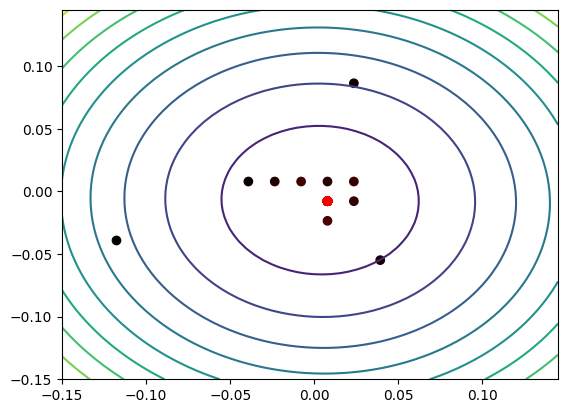

In [130]:
ga = GeneticAlgorithm(16,2, g_x, [-2,2], num_steps=30, crossover_probability=0.9, given_minimal_value = g_x(0,0))
ga.run(range_x=[-0.15,0.15], range_y=[-0.15,0.15], precision=0.005)

How we can observe, to high mutation probability, slow down our minimization

Parameters:
Chromosome lengths: 16,
obj_func_num_args: 2,
objective_function: g_x,
aoi: [-2, 2],
population_size: 1000,
tournament_size: 2,
mutation_probability: 0.1,
crossover_probability: 0.8,
num_steps: 20

Start! initial best value:  0.4975020376554981  for arguments:  [0.007843137254901933, 0.0235294117647058] , difference = 0.0008710111550408461
Iteration: 1, Best value:  0.49867738043740767  for arguments:  [0.007843137254901933, 0.039215686274509665] , difference = 0.002046353936950407
Iteration: 2, Best value:  0.4968068908624435  for arguments:  [0.007843137254901933, 0.007843137254901933] , difference = 0.00017586436198624433
Iteration: 3, Best value:  0.4968068908624435  for arguments:  [0.007843137254901933, 0.007843137254901933] , difference = 0.00017586436198624433
Iteration: 4, Best value:  0.4968068908624435  for arguments:  [0.007843137254901933, 0.007843137254901933] , difference = 0.00017586436198624433
Iteration: 5, Best value:  0.4968068908624435  for arguments:  

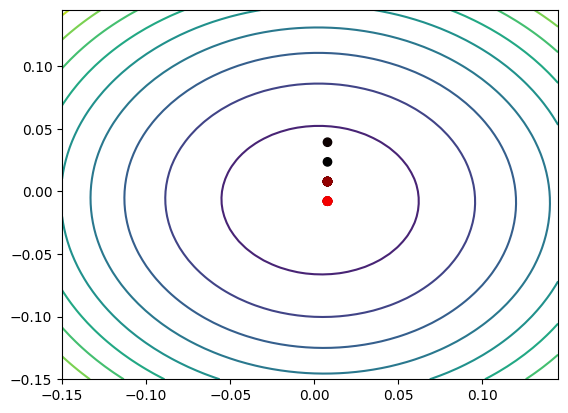

In [129]:
ga = GeneticAlgorithm(16,2, g_x, [-2,2], num_steps=20, mutation_probability=0.1, given_minimal_value = g_x(0,0))
ga.run(range_x=[-0.15,0.15], range_y=[-0.15,0.15], precision=0.005)

Parameters:
Chromosome lengths: 16,
obj_func_num_args: 2,
objective_function: g_x,
aoi: [-2, 2],
population_size: 1000,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.8,
num_steps: 20

Start! initial best value:  0.49867738043740767  for arguments:  [0.007843137254901933, 0.039215686274509665] , difference = 0.002046353936950407
Iteration: 1, Best value:  0.499347571372063  for arguments:  [-0.0235294117647058, 0.039215686274509665] , difference = 0.0027165448716057194
Iteration: 2, Best value:  0.4981844898656534  for arguments:  [-0.0235294117647058, 0.0235294117647058] , difference = 0.0015534633651961283
Iteration: 3, Best value:  0.4971948265881573  for arguments:  [0.0235294117647058, 0.007843137254901933] , difference = 0.0005638000877000171
Iteration: 4, Best value:  0.4971948265881573  for arguments:  [0.0235294117647058, 0.007843137254901933] , difference = 0.0005638000877000171
Iteration: 5, Best value:  0.496973354567466  for arguments:  [0.0235294

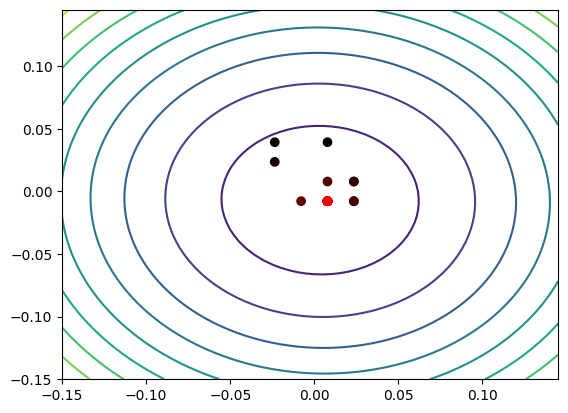

In [119]:
ga = GeneticAlgorithm(16,2, g_x, [-2,2], num_steps=20, given_minimal_value = g_x(0,0))
ga.run(range_x=[-0.15,0.15], range_y=[-0.15,0.15], precision=0.005)

Parameters:
Chromosome lengths: 16,
obj_func_num_args: 2,
objective_function: g_x,
aoi: [-2, 2],
population_size: 1000,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.2,
num_steps: 20

Start! initial best value:  0.49867738043740767  for arguments:  [0.007843137254901933, 0.039215686274509665] , difference = 0.002046353936950407
Iteration: 1, Best value:  0.49867738043740767  for arguments:  [0.007843137254901933, 0.039215686274509665] , difference = 0.002046353936950407
Iteration: 2, Best value:  0.49867738043740767  for arguments:  [0.007843137254901933, 0.039215686274509665] , difference = 0.002046353936950407
Iteration: 3, Best value:  0.49867738043740767  for arguments:  [0.007843137254901933, 0.039215686274509665] , difference = 0.002046353936950407
Iteration: 4, Best value:  0.49907699119006455  for arguments:  [0.0235294117647058, 0.039215686274509665] , difference = 0.002445964689607283
Iteration: 5, Best value:  0.497598181897857  for arguments:  [-0

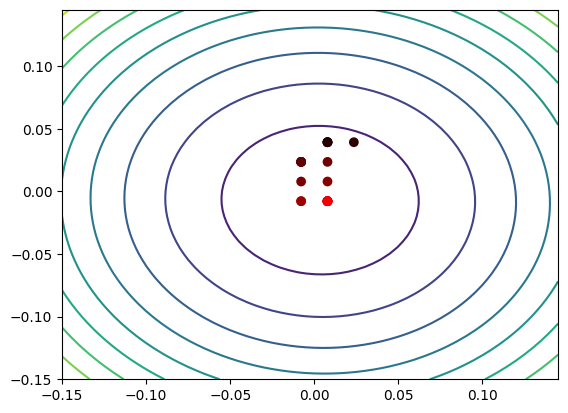

In [120]:
ga = GeneticAlgorithm(16,2, g_x, [-2,2], num_steps=20, crossover_probability=0.2, given_minimal_value = g_x(0,0))
ga.run(range_x=[-0.15,0.15], range_y=[-0.15,0.15], precision=0.005)

Parameters:
Chromosome lengths: 16,
obj_func_num_args: 2,
objective_function: g_x,
aoi: [-2, 2],
population_size: 1000,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.9,
num_steps: 20

Start! initial best value:  0.4983891369134177  for arguments:  [-0.03921568627450989, -0.007843137254901933] , difference = 0.001758110412960423
Iteration: 1, Best value:  0.4983891369134177  for arguments:  [-0.03921568627450989, -0.007843137254901933] , difference = 0.001758110412960423
Iteration: 2, Best value:  0.4983891369134177  for arguments:  [-0.03921568627450989, -0.007843137254901933] , difference = 0.001758110412960423
Iteration: 3, Best value:  0.49907699119006455  for arguments:  [0.0235294117647058, 0.039215686274509665] , difference = 0.002445964689607283
Iteration: 4, Best value:  0.49789610445680765  for arguments:  [0.0235294117647058, 0.0235294117647058] , difference = 0.0012650779563503911
Iteration: 5, Best value:  0.496973354567466  for arguments:  [0.023

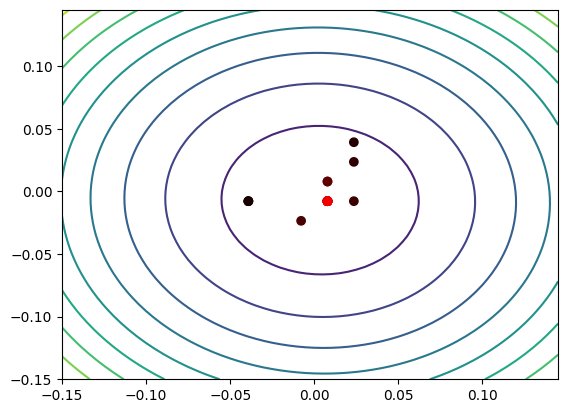

In [121]:
ga = GeneticAlgorithm(16,2, g_x, [-2,2], num_steps=20, crossover_probability=0.9, given_minimal_value = g_x(0,0))
ga.run(range_x=[-0.15,0.15], range_y=[-0.15,0.15], precision=0.005)

Parameters:
Chromosome lengths: 256,
obj_func_num_args: 2,
objective_function: g_x,
aoi: [-2, 2],
population_size: 1000,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.8,
num_steps: 10

Start! initial best value:  0.5036877135207891  for arguments:  [-0.06460112418247288, 0.04465948501630024] , difference = 0.007056687020331853
Iteration: 1, Best value:  0.500223894607824  for arguments:  [0.05721611022664419, -0.036131986681577466] , difference = 0.0035928681073667534
Iteration: 2, Best value:  0.49802280517826336  for arguments:  [0.006627578594249339, -0.045468045993710904] , difference = 0.0013917786778060992
Iteration: 3, Best value:  0.49662424809784106  for arguments:  [0.0025761755359541283, 0.0002868187039277714] , difference = 6.778402616203216e-06
Iteration: 4, Best value:  0.49662424809781414  for arguments:  [0.0025761755359541283, 0.0002868187020186319] , difference = 6.778402643126125e-06
Iteration: 5, Best value:  0.49662424809781414  for argum

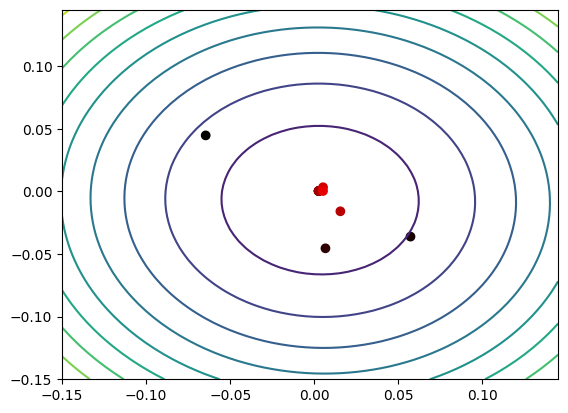

In [122]:
ga = GeneticAlgorithm(256,2, g_x, [-2,2], num_steps=10, given_minimal_value = g_x(0,0))
ga.run(range_x=[-0.15,0.15], range_y=[-0.15,0.15], precision=0.005)

Parameters:
Chromosome lengths: 128,
obj_func_num_args: 2,
objective_function: g_x,
aoi: [-20, 20],
population_size: 1000,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.8,
num_steps: 30

Start! initial best value:  0.8641285002631477  for arguments:  [-0.6723545361518148, 0.03810202084283176] , difference = 0.36749747376269043
Iteration: 1, Best value:  0.8764688836362411  for arguments:  [0.5073589394439502, 0.4651754676373976] , difference = 0.37983785713578383
Iteration: 2, Best value:  0.8764688836362411  for arguments:  [0.5073589394439502, 0.4651754676373976] , difference = 0.37983785713578383
Iteration: 3, Best value:  0.8883623973207629  for arguments:  [0.18954229369124675, -0.7389647489672022] , difference = 0.3917313708203057
Iteration: 4, Best value:  0.5398128949088724  for arguments:  [-0.07678085506556087, -0.20302582825595294] , difference = 0.04318186840841515
Iteration: 5, Best value:  0.5398128949088724  for arguments:  [-0.0767808550655608

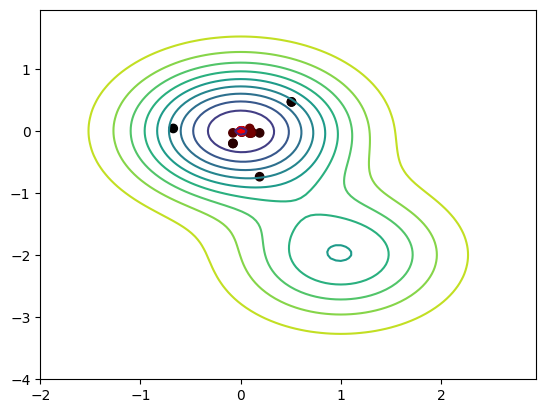

In [123]:
ga = GeneticAlgorithm(128,2, g_x, [-20,20], given_minimal_value = g_x(0,0))
ga.run()

Even for such a large range, the algorithm finds the minimum.

Parameters:
Chromosome lengths: 256,
obj_func_num_args: 2,
objective_function: g_x,
aoi: [-1, 1],
population_size: 1000,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.8,
num_steps: 30

Start! initial best value:  0.4977498557197601  for arguments:  [-0.03070808169799233, -0.0027433622295306437] , difference = 0.0011188292193028415
Iteration: 1, Best value:  0.496800088541464  for arguments:  [0.008341570742149251, 0.007438237234792977] , difference = 0.00016906204100675115
Iteration: 2, Best value:  0.49679949578235894  for arguments:  [0.008341570742149251, 0.007417219502503736] , difference = 0.0001684692819016731
Iteration: 3, Best value:  0.496592992848162  for arguments:  [0.0060501490173672234, -0.0032131510667141594] , difference = 3.803365229526623e-05
Iteration: 4, Best value:  0.4965960683489127  for arguments:  [0.008341570526060993, -0.007019710278369118] , difference = 3.495815154458404e-05
Iteration: 5, Best value:  0.49659606835100745  for argu

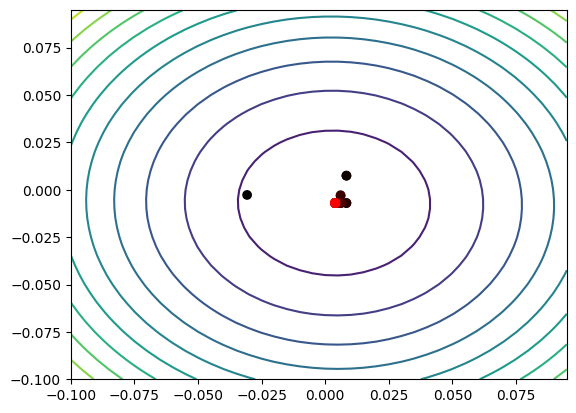

In [124]:
ga = GeneticAlgorithm(256,2, g_x, [-1,1], given_minimal_value = g_x(0,0))
ga.run(range_x=[-0.1,0.1], range_y=[-0.1,0.1], precision=0.005)

Parameters:
Chromosome lengths: 16,
obj_func_num_args: 2,
objective_function: g_x,
aoi: [-1, 1],
population_size: 2000,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.8,
num_steps: 30

Start! initial best value:  0.4980885397420334  for arguments:  [0.019607843137254832, -0.04313725490196074] , difference = 0.0014575132415761138
Iteration: 1, Best value:  0.49674022928655265  for arguments:  [-0.0039215686274509665, 0.0039215686274509665] , difference = 0.00010920278609538592
Iteration: 2, Best value:  0.49691485944202246  for arguments:  [0.0039215686274509665, 0.0117647058823529] , difference = 0.00028383294156519856
Iteration: 3, Best value:  0.49723147086229436  for arguments:  [0.019607843137254832, -0.027450980392156876] , difference = 0.0006004443618370936
Iteration: 4, Best value:  0.49666240124882327  for arguments:  [0.0117647058823529, -0.0117647058823529] , difference = 3.137474836600873e-05
Iteration: 5, Best value:  0.49666240124882327  for argum

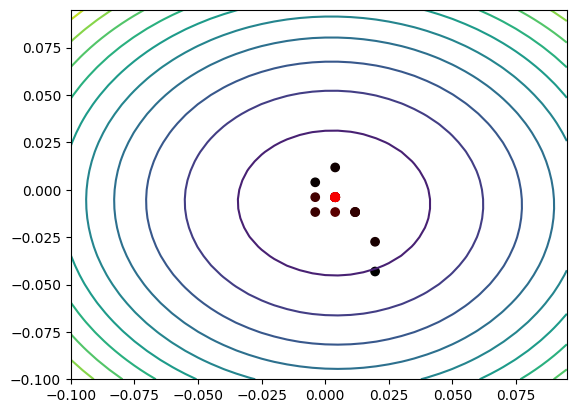

In [125]:
ga = GeneticAlgorithm(16,2, g_x, [-1,1], given_minimal_value = g_x(0,0), population_size=2000)
ga.run(range_x=[-0.1,0.1], range_y=[-0.1,0.1], precision=0.005)

In cases where the length of chromosomes is too small, there is no more accurate solution for such a resolution

Another function 2d: 
Parameters:
Chromosome lengths: 20,
obj_func_num_args: 2,
objective_function: custom_function,
aoi: [-3, 3],
population_size: 1500,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.8,
num_steps: 10

Start! initial best value:  -0.39821744375183016  for arguments:  [-0.7536656891495603, 0.04985337243401755] , difference = 0.002271168345420016
Iteration: 1, Best value:  -0.3977264658276247  for arguments:  [-0.724340175953079, -0.055718475073313734] , difference = 0.002762146269625454
Iteration: 2, Best value:  -0.3977264658276247  for arguments:  [-0.724340175953079, -0.055718475073313734] , difference = 0.002762146269625454
Iteration: 3, Best value:  -0.39824111551572855  for arguments:  [-0.724340175953079, -0.04985337243401755] , difference = 0.002247496581521624
Iteration: 4, Best value:  -0.39984036449744864  for arguments:  [-0.7126099706744866, -0.008797653958944274] , difference = 0.0006482475998015325
Iteration: 5, Best value:  -0.3

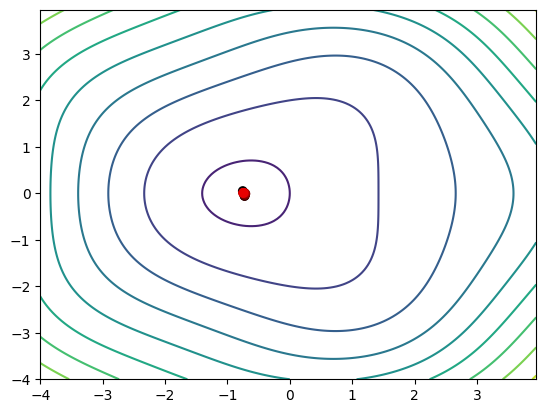

In [126]:
print("Another function 2d: ")
ga = GeneticAlgorithm(20,2, custom_function, [-3,3], num_steps=10, population_size=1500, given_minimal_value=custom_function(-7.39086554e-01,-4.15399668e-06) )
ga.run(range_x=[-4,4], range_y=[-4,4], precision=0.05)

In [127]:
print("Another function 3d: ")
ga = GeneticAlgorithm(30,3, custom_function_3d, [-2,2], num_steps=30, mutation_probability=0.3, crossover_probability=0.8, population_size=1500, given_minimal_value=custom_function_3d(0,0,0))
ga.run(plot=False)

Another function 3d: 
Parameters:
Chromosome lengths: 30,
obj_func_num_args: 3,
objective_function: custom_function_3d,
aoi: [-2, 2],
population_size: 1500,
tournament_size: 2,
mutation_probability: 0.3,
crossover_probability: 0.8,
num_steps: 30

Start! initial best value:  0.0009020100263123942  for arguments:  [-0.0058651026392961825, 0.009775171065493637, 0.009775171065493637] , difference = 0.0009020100263123942
Iteration: 1, Best value:  0.050319059728102626  for arguments:  [-0.04105571847507328, 0.013685239491691092, -0.10361681329423256] , difference = 0.050319059728102626
Iteration: 2, Best value:  0.008100655510816068  for arguments:  [-0.03714565004887582, 0.025415444770283457, -2.0] , difference = 0.008100655510816068
Iteration: 3, Best value:  0.050319059728102626  for arguments:  [-0.04105571847507328, 0.013685239491691092, -0.10361681329423256] , difference = 0.050319059728102626
Iteration: 4, Best value:  0.002614163720404119  for arguments:  [-0.0058651026392961825, 0.

In [128]:
print("Another function 6d: ")
ga = GeneticAlgorithm(120,6, custom_function_6d, [-1,1], num_steps=60, crossover_probability=0.8, population_size=1500, given_minimal_value=custom_function_6d(0,0,0, 0, 0, 0))
ga.run(plot=False)

Another function 6d: 
Parameters:
Chromosome lengths: 120,
obj_func_num_args: 6,
objective_function: custom_function_6d,
aoi: [-1, 1],
population_size: 1500,
tournament_size: 2,
mutation_probability: 0.05,
crossover_probability: 0.8,
num_steps: 60

Start! initial best value:  0.9662570004119334  for arguments:  [0.06964404072193209, -0.1520663757957228, 0.14936556755596886, -0.2429401807214553, 0.011475573993276589, 0.22730562906802088] , difference = 0.9662570004119334
Iteration: 1, Best value:  0.9662570004119334  for arguments:  [0.06964404072193209, -0.1520663757957228, 0.14936556755596886, -0.2429401807214553, 0.011475573993276589, 0.22730562906802088] , difference = 0.9662570004119334
Iteration: 2, Best value:  0.6565578031658036  for arguments:  [0.20439644279140734, 0.02566816870514743, 0.21064492287151615, 0.05534844908566394, 0.12200271797439388, -0.06853777745988598] , difference = 0.6565578031658036
Iteration: 3, Best value:  0.6172391383127863  for arguments:  [0.069644040

## Conclusion
The genetic algorithm doesn't have problems finding the minimum of a function. Its advantage over the gradient method is that it never gets stuck in a local minimum. Of course, it's essential to establish an accurate population diversity. With variables such as mutation probability, crossover probability, population size, and the number of generations, we can calibrate our algorithm to obtain the best results. Mutation probability is responsible for maintaining diversity during the evolution process. Another important variable responsible for this is the population size. A larger population is more diverse. The crossover probability should be higher if we want to utilize more from the previous generation. Proper values for mutation probability should not be too high if we want to maintain progress. Similarly, the crossover probability should not be too low for the very same reason. Population size and the number of generations have a significant impact on computing time, and we need to adjust them accurately.